# EZBattery demo
------------------------------------------
## Redox targeting flow battery
### Cathode electrochemical reaction (left to right for charging):  
$$
[Fe^{II}(CN)_6]^{4-} \rightleftharpoons [Fe^{III}(CN)_6]^{3-} + e^-
$$
### Anode electrochemical reaction  (left to right for charging):  
$$
S_2^{2-} + e^- \rightleftharpoons 2 S^{2-}
$$

### Catholyte tank solid-liquid chemical reaction (left to right for charging):

$$
4[Fe^{III}(CN)_6]^{3-} + \text{M}_4\text{Fe}_4^{II}[Fe^{II}(CN)_6]_3 \cdot (14 + x)H_2O \,(\text{solid}) \rightleftharpoons  4M^+ + 4[Fe^{II}(CN)_6]^{4-} + \text{Fe}_4^{III}[Fe^{II}(CN)_6]_3 \cdot 14H_2O \,(\text{solid}) + xH_2O 
$$

#### M is Na or K.





------------------------------------------
## Table of contents
### 1. Import all the necessary packages
### 2. Load the parameter data file
### 3. Load the experiment data file
### 4. Model validation
### 5. Results visualization

### 1. Import all the necessary packages

In [1]:
import os, copy
import numpy as np
import matplotlib.pyplot as plt
from EZBattery import BatteryParameter,LoadExperiment, RFB
import pandas as pd

### 2. Load the parameter data file

In [2]:
WorkDir = os.getcwd() + os.sep + 'data' 
SDPFNames = 'SDPF_rtfb.xlsx'
SDPFPath = WorkDir + os.sep + SDPFNames
PP1 = BatteryParameter(SDPFPath)

### 3. Load the experiment data file and the reaction rate of solid material calibration data file. The reaction rate of the solid material is the input and it needs to be calibrated by experiment.

In [3]:
PP0 = copy.deepcopy(PP1)
PP0.CalibrationOutputPath = SDPFPath
fname = PP0.Experiment.split('\\')[-1]
pname = "rdc.csv"
EXPPath1 = WorkDir + os.sep + fname
EXPPath2 = WorkDir + os.sep + pname
df1 = pd.read_csv(EXPPath1, names = ["time","voltage"],header=0,encoding="ISO-8859-1")
df2 = pd.read_csv(EXPPath2, names = ["charge","discharge"],header=0,encoding="ISO-8859-1")

### 4. Model validation

In [4]:
nc1 = 1
v1=[]
v2=[]
v3=[]
v4=[]
v5=[]
v6=[]
ya1=[]
ya2=[]
PP1.CycleNumber = nc1
PP1.Display = 'no'
PP1.PerformanceCalculation='no'

current=PP1.Current
transfer=current/96485.3321

n1=10
n2=n1*3-2
coini=PP1.CathodeOxidant1InitialConcentrationInCathode#tank
crini=PP1.CathodeReductant1InitialConcentrationInCathode#cell

ctt=1.03461*3600
ct1=1.03461*3600*0.1
ct2=1.03461*3600*0.9

dtt=1.03*3600
dt1=1.03*3600*0.1
dt2=1.03*3600*0.9

interval=0
xc111=np.linspace(0, ct1,num=n1)
xc11 = xc111[:-1]
xc112=np.linspace(ct1, ct2,num=n1)
xc12 = xc112[:-1]
xc13=np.linspace(ct2, ctt,num=n1)
xx1=np.concatenate((xc11,xc12,xc13))

xd111=np.linspace(0, dt1,num=n1)
xd11 = xd111[:-1]
xd112=np.linspace(dt1, dt2,num=n1)
xd12 = xd112[:-1]
xd13=np.linspace(dt2, dtt,num=n1)
xx2=np.concatenate((xd11,xd12,xd13))

xx2=xx2+ctt+interval

x1=np.concatenate((xx1,xx2))

temp1=[]
temp2=[]

v=0.0002
temp1.append(0.0)
for i in range(len(xx1)-1):
    temp1.append(xx1[i+1] - xx1[i])

for i in range(len(temp1)):
    temp2.append(temp1[i]*current/96485.3321/2/v)

temptotal1=0.0   
for i in temp2:
    temptotal1 += i
    ya1.append(temptotal1)      

    
temp1=[]
temp2=[]
temp1.append(0.0)
for i in range(len(xx2)-1):
    temp1.append(xx2[i+1] - xx2[i])

for i in range(len(temp1)):
    temp2.append(temp1[i]*current/96485.3321/2/v)

temptotal1=0.0   
for i in temp2:
    temptotal1 += i
    ya2.append(temptotal1)      

a1=df2["charge"]
a2=df2["discharge"]
r1 = pd.concat([pd.Series([0.0]), a1]).reset_index(drop=True)
r2 = pd.concat([pd.Series([0.0]), a2]).reset_index(drop=True)
tsolid1=[]
tliquid1=[]
TransferVector1=[]


tx1=[0.0]
tx1.extend(-xx1[i] + xx1[i + 1] for i in range(len(xx1) - 1))
for i in range(1,n2):
    tt1=tx1[i]*transfer
    TransferVector1.append(tt1)
    tt2=r1[i]*tx1[i]
    tsolid1.append(tt2)
    tt3=tt1-tt2
    tliquid1.append(tt3)

cccell1=[0] * (len(tliquid1) + 1)
cccell1[0]=(PP1.CathodeOxidant1InitialConcentrationInCathode)
cccell1[0]=crini
for i in range (len(tliquid1)):
    cccell1[i+1]=cccell1[i]-tliquid1[i]/0.000015
        
y1=cccell1

for i in range(n2):
    
    cliquid=y1[i]
    ccc1=(crini-cliquid)+coini
   
    PP1.CathodeReductant1InitialConcentrationInCathode=cliquid
    PP1.CathodeOxidant1InitialConcentrationInCathode=ccc1

    PP1.AnodeOxidant1InitialConcentrationInAnode=1000-(ya1[i])
    PP1.AnodeReductant1InitialConcentrationInAnode=ya1[i]*2
         
    Re1 = RFB(PP1)
    tv1=Re1['Potentials']['Ec_V'] 
    v1.append(tv1[0])


    aac1=PP1.AnodeOxidant1InitialConcentrationInAnode
    aac2=PP1.AnodeReductant1InitialConcentrationInAnode
cac1=y1[-1]


tsolid2=[]
tliquid2=[]
TransferVector2=[]

tx2=[0.0]
tx2.extend(-xx2[i] + xx2[i + 1] for i in range(len(xx2) - 1))
for i in range(1,n2):
    tt1=tx2[i]*transfer
    TransferVector2.append(tt1)
    tt2=r2[i]*tx2[i]
    
    tsolid2.append(tt2)
    tt3=tt1-tt2
    tliquid2.append(tt3)

cccell2=[0] * (len(tliquid2) + 1)
cccell2[0]=(PP1.CathodeOxidant1InitialConcentrationInCathode)
cccell2[0]=crini-cac1/PP1.CathodeElectronNumber

for i in range (len(tliquid2)):
    cccell2[i+1]=cccell2[i]-tliquid2[i]/0.000015
    
y2=cccell2

PP1.InitialStatus=-1
for i in range(n2):
    ccc2=(crini-y2[i])
    PP1.CathodeReductant1InitialConcentrationInCathode=ccc2
    PP1.CathodeOxidant1InitialConcentrationInCathode=y2[i]
 
    PP1.AnodeOxidant1InitialConcentrationInAnode=(ya2[i])+aac1
    PP1.AnodeReductant1InitialConcentrationInAnode=aac2-ya2[i]*2
    
    Re1 = RFB(PP1)
        
    tv1=Re1['Potentials']['Ec_V'] #######3
    v4.append(tv1[0])




### 5. Results visualization

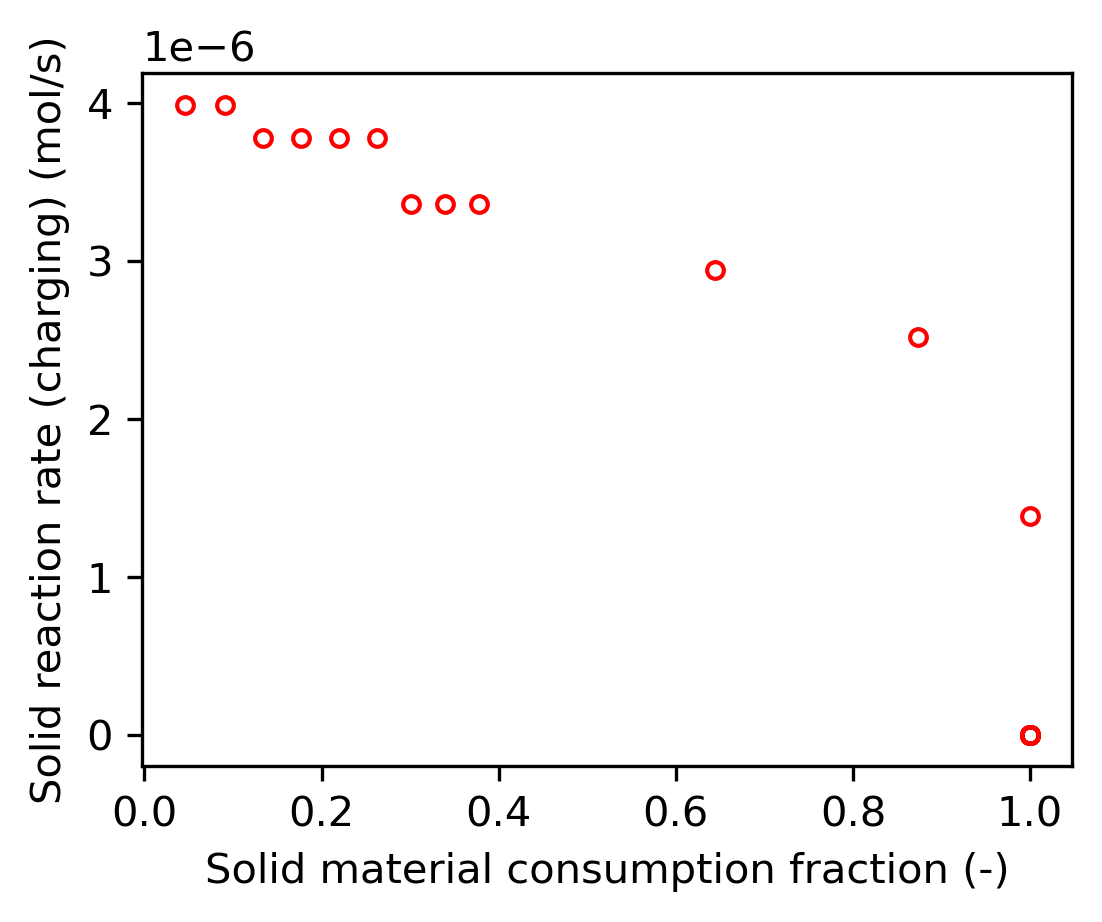

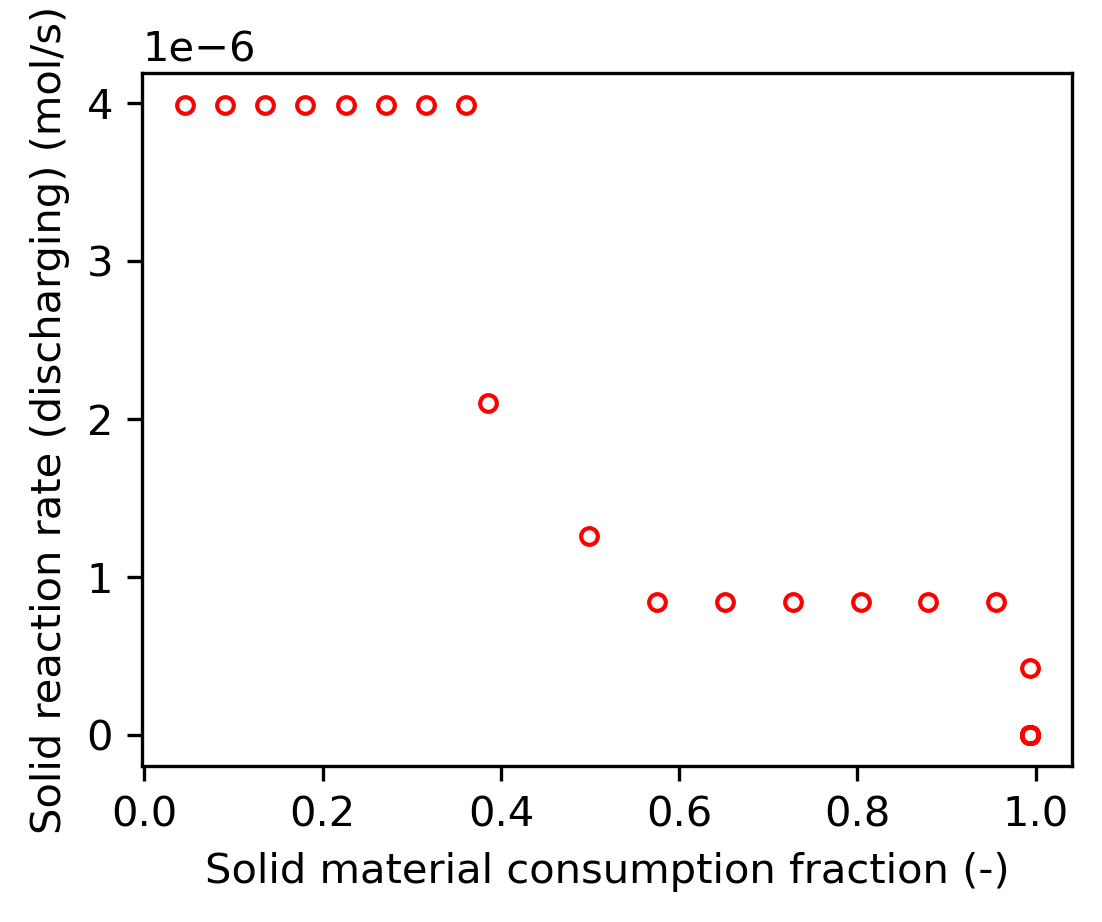

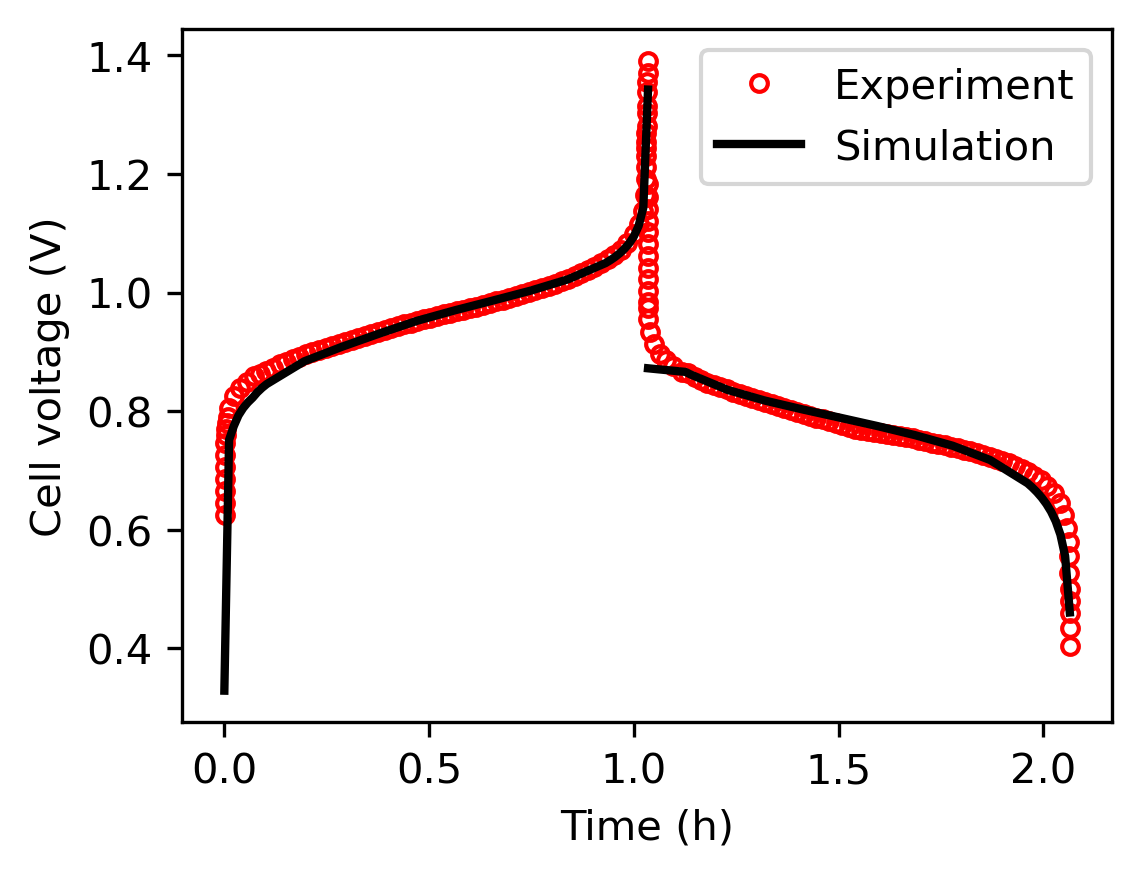

In [5]:
plt.figure(figsize=(4, 3),dpi=300)
plt.xlabel('Solid material consumption fraction (-)')
plt.ylabel('Solid reaction rate (charging) (mol/s)')
s1=np.sum(tsolid1)
txx11=[]
txx1=np.cumsum(tsolid1)
for i in range(len(txx1)):
    txx11.append(txx1[i]/s1)

plt.plot(txx11,r1[1:],'ro', 
    markerfacecolor='none', 
    markersize=4  )

plt.figure(figsize=(4, 3),dpi=300)
plt.xlabel('Solid material consumption fraction (-)')
plt.ylabel('Solid reaction rate (discharging) (mol/s)')
s2=np.sum(tsolid2)
txx12=[]
txx2=np.cumsum(tsolid2)
for i in range(len(txx2)):
    txx12.append(txx2[i]/s1)
plt.plot(txx12,r2[1:],'ro', 
    markerfacecolor='none', 
    markersize=4 )

plt.figure(figsize=(4, 3),dpi=300)
xx=df1["time"]
yy=df1["voltage"]
plt.xlabel('Time (h)')
plt.ylabel('Cell voltage (V)')

exx1=df1["time"].iloc[:90]
eyy1=df1["voltage"].iloc[:90]
exx2=df1["time"].iloc[90:]
eyy2=df1["voltage"].iloc[90:]
plt.plot(exx1, eyy1, 'ro',label="Experiment", markerfacecolor='none',  markersize=4 )
plt.plot(exx2, eyy2,'ro', markerfacecolor='none', markersize=4 )
plt.plot(xx1/3600,v1,linewidth=2,label='Simulation',color='black')
plt.plot(xx2/3600,v4,linewidth=2,color='black')
plt.legend()

